---
title: "Age prediction with methylation data"
author: "Rogério Ribeiro"
date: "Jun 6 2023" 
format: 
    html: 
        code-fold: true

---

# Age prediction in lung with methylation data

In [1]:
# Load libraries
import time

import numpy as np
import pandas as pd
from joblib import Memory

from sklearn.preprocessing import QuantileTransformer
from lighGBMPipelineMeth import LGBMPipeline

SEED = 42

In [2]:
memory = Memory('cache')

@memory.cache
def load_lung_data() -> pd.DataFrame:
    return pd.read_csv("../../data/methylation_lung.csv")


In [3]:
results_dict = {}

def update_results_dict(entry_name, mean_runtime, mean_n_feats, 
                        cv_r2_mean, cv_r2_sd, cv_rmse_mean, cv_rmse_sd, 
                        r2_test_mean, r2_test_sd, rmse_test_mean, rmse_test_sd):


    results_dict[entry_name] = {"speed_mean": mean_runtime, "n_feats_mean": mean_n_feats,
                                 "cv_r2_mean": cv_r2_mean, "cv_r2_sd": cv_r2_sd,
                                 "cv_rmse_mean": cv_rmse_mean, "cv_rmse_sd": cv_rmse_sd,
                                 "r2_test_mean": r2_test_mean, "r2_test_sd": r2_test_sd,
                                 "rmse_test_mean": rmse_test_mean, "rmse_test_sd": rmse_test_sd}

In [4]:
def pretty_results_table(results_dict):
    results_df = pd.DataFrame(results_dict).T.sort_values(by='cv_r2_mean', ascending=False)
    html = results_df.style.background_gradient(cmap='plasma', low=0.3, high=1,
                                               subset=["cv_r2_mean", "r2_test_mean"]).background_gradient(cmap='viridis',
                                               low=1, high=0.3, subset=["cv_rmse_mean", "rmse_test_mean"]).format(precision=2)
    return html


## Load Lung dataset and metadta

In [5]:
#Load Lung methylatio data 
lung = load_lung_data()

#Load metadata
metadata = pd.read_csv(r"../../metadata/metadata.withSampleID.csv")
metadata = metadata[metadata['tissue'] == "Lung"]
#Load probe info
probe_info = pd.read_csv(r"../../metadata/methylation_epic_v1.0b5.csv")
probe_info = probe_info[probe_info["CHR_hg38"].notna()] #Remove NA probes in the CHR_hg38 genome

C:\Users\Acer\AppData\Local\Temp\ipykernel_25900\4122166725.py:8: DtypeWarning: Columns (2,4,42,47) have mixed types. Specify dtype option on import or set low_memory=False.
  probe_info = pd.read_csv(r"../../metadata/methylation_epic_v1.0b5.csv")


## Filter probes
Filter Probes in the X an Y chromossome as well as probes of the MtDNA

In [6]:
lung = lung.set_index("probe")

# Filter out probes in the X, Y 
chrxy_probes = probe_info[(probe_info['CHR_hg38'] == 'chrX') | (probe_info['CHR_hg38'] == 'chrY')]['Name'].tolist()
lung = lung[~lung.index.isin(chrxy_probes)]
        
# Filter ou probes in the M chromossome
chrM_probes = probe_info[(probe_info['CHR_hg38'] == 'chrM')]['Name'].tolist()
lung = lung[~lung.index.isin(chrM_probes)]

## Preprocess the data

- Split the data intro train-test dataset
- Test data is already set


In [7]:
lung_test_set = pd.read_csv("../../metadata/lung_test_metadata.v2.csv")

metadata = metadata.set_index("FullSampleID")
ages = metadata["AGE"]

#Separate the metadata
metadata_test = metadata.loc[metadata["SUBJID"].isin(lung_test_set["subject_id"])]
metadata_train = metadata.loc[~metadata["SUBJID"].isin(lung_test_set["subject_id"])]

#Separate the methylation data 
# Transpose the dataframe
lung_t = lung.transpose()

X_train, y_train = lung_t.loc[metadata_train.index], list(ages.loc[metadata_train.index])
X_test, y_test = lung_t.loc[metadata_test.index], list(ages.loc[metadata_test.index])

## Define cross validation scheme (5 fold cross validation)

In [8]:
from sklearn.model_selection import StratifiedKFold

n_folds = 5

age_bins = np.arange(18, 76, 5)
y_bins = pd.cut(y_train, age_bins, labels=False)
skf_gen = StratifiedKFold(n_folds).split(X_train, y_bins)

folds = [[t[0], t[1]] for t in skf_gen]

c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


In [9]:
def methylation_data_preprocessing(X_train, X_valid, X_test, qt = True):
    """Preprocess the data by applying Quartile normalization and/or RobustScaler""" 
    if qt == True: 
        qt = QuantileTransformer(n_quantiles = 100, random_state=SEED, output_distribution = "normal")
        qt = qt.fit(X_train)
        X_train = pd.DataFrame(qt.transform(X_train), columns=X_train.columns, index=X_train.index)
        X_valid = pd.DataFrame(qt.transform(X_valid), columns=X_valid.columns, index=X_valid.index)   
        X_test = pd.DataFrame(qt.transform(X_test), columns=X_test.columns, index=X_test.index)   

    return X_train, X_valid, X_test

## Baseline model (This is the baseline model that will be used as a comparison)

In [ ]:
%matplotlib inline

hyper_params = {
    "importance_type": "gain",
    'task': 'train',
    'boosting_type': 'gbdt', 
    'objective': 'regression',
    "lambda_l1": 0.01, "lambda_l2": 0.1, "max_depth": 100
}

runtimes = []
features = []
r2_scores = []
rmse_scores = []
r2_scores_test = []
rmse_scores_test = []

model_name = "baseline"

for cv_train_idx, cv_valid_idx in folds: 
    X_train_scaled, X_valid_scaled, X_test_scale = methylation_data_preprocessing(X_train.iloc[cv_train_idx], X_train.iloc[cv_valid_idx], X_test)
    y_fold_train, y_fold_valid = np.array(y_train)[cv_train_idx], np.array(y_train)[cv_valid_idx]

    start = time.time()
    lgbm = LGBMPipeline(hyperparams = hyper_params, rand=SEED, n_jobs=6)
    lgbm.fit(X_train_scaled, y_fold_train)
    runtime = time.time() - start
    runtimes.append(runtime)
    
    features.append(len(lgbm.model.feature_importances_))

    metrics_valid = lgbm.compute_metrics(y_fold_valid, lgbm.predict(X_valid_scaled))
    r2_scores.append(metrics_valid["r2"])
    rmse_scores.append(metrics_valid["rmse"])

    metrics_test = lgbm.compute_metrics(y_test, lgbm.predict(X_test_scale))
    r2_scores_test.append(metrics_test["r2"])
    rmse_scores_test.append(metrics_test["rmse"])

    

update_results_dict(model_name, np.mean(runtime), np.mean(features), 
                    np.mean(r2_scores), np.std(r2_scores), 
                    np.mean(rmse_scores), np.std(rmse_scores),
                    np.mean(r2_scores_test), np.std(r2_scores_test), 
                    np.mean(rmse_scores_test), np.std(rmse_scores_test))

### Filter based on fold change (difference betweeh the highest and lowest value)

In [11]:
def compute_logFC(meth): 
    eps = 0.001
    meth_min = meth.min()
    meth_min[meth_min<eps] = eps
    return (meth.max() / meth_min)

def filter_by_fold_change(meth, fold):
    fold_change_mask = compute_logFC(meth) > fold
    return meth.loc[:, fold_change_mask].columns

In [12]:
hyper_params = {
    "importance_type": "gain",
    'task': 'train',
    'boosting_type': 'gbdt', 
    'objective': 'regression',
    "lambda_l1": 0.01, "lambda_l2": 0.1, "max_depth": 100
}



for foldChange in [10, 15, 20]:
    #Metrics 
    runtimes = []
    features = []
    r2_scores = []
    rmse_scores = []
    r2_scores_test = []
    rmse_scores_test = []

    #Model name
    model_name = f"fc_{foldChange}_treshold"

    
    for cv_train_idx, cv_valid_idx in folds: 
        start = time.time()
        #Preprocessing
        X_fold_train, X_fold_valid = X_train.iloc[cv_train_idx], X_train.iloc[cv_valid_idx]
        y_fold_train, y_fold_valid = np.array(y_train)[cv_train_idx], np.array(y_train)[cv_valid_idx]
        
        ## Filter by foldchange
        fold_change_feats = filter_by_fold_change(X_fold_train, foldChange)
        X_train_filtered, X_valid_filtered, X_test_filtered = X_fold_train[fold_change_feats], X_fold_valid[fold_change_feats], X_test[fold_change_feats]

        ## Scale the dataset    
        X_train_scaled, X_valid_scaled, X_test_scale = methylation_data_preprocessing(X_train_filtered, X_valid_filtered,X_test_filtered)

        #LGBM run
        lgbm = LGBMPipeline(hyperparams = hyper_params, rand=SEED, n_jobs=6, model_name=model_name)
        lgbm.fit(X_train_scaled, y_fold_train)
        runtime = time.time() - start

        #Add Run metrics
        runtimes.append(runtime)
        features.append(len(lgbm.model.feature_importances_))

        #Metrics on train valid fold
        metrics_valid = lgbm.compute_metrics(y_fold_valid, lgbm.predict(X_valid_scaled))
        r2_scores.append(metrics_valid["r2"])
        rmse_scores.append(metrics_valid["rmse"])
        #Metrics on test set
        metrics_test = lgbm.compute_metrics(y_test, lgbm.predict(X_test_scale))
        r2_scores_test.append(metrics_test["r2"])
        rmse_scores_test.append(metrics_test["rmse"])


    ## Update the result dictionary
    update_results_dict(model_name, np.mean(runtime), np.mean(features), 
                        np.mean(r2_scores), np.std(r2_scores), 
                        np.mean(rmse_scores), np.std(rmse_scores),
                        np.mean(r2_scores_test), np.std(r2_scores_test), 
                        np.mean(rmse_scores_test), np.std(rmse_scores_test))


[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 w

### Correlation based method

In [13]:
from scipy.stats import spearmanr


hyper_params = {
    "importance_type": "gain",
    'task': 'train',
    'boosting_type': 'gbdt', 
    'objective': 'regression',
    "lambda_l1": 0.01, "lambda_l2": 0.1, "max_depth": 100
}



for thresh in [0.3, 0.4, 0.5]:
    #Metrics 
    runtimes = []
    features = []
    r2_scores = []
    rmse_scores = []
    r2_scores_test = []
    rmse_scores_test = []

    #Model name
    model_name = f"cor_{thresh}"

    
    for cv_train_idx, cv_valid_idx in folds: 
        start = time.time()
        #Preprocessing
        X_fold_train, X_fold_valid = X_train.iloc[cv_train_idx], X_train.iloc[cv_valid_idx]
        y_fold_train, y_fold_valid = np.array(y_train)[cv_train_idx], np.array(y_train)[cv_valid_idx]
        ## Filter by correlation
        cor_and_p_values = X_fold_train.apply(lambda col: spearmanr(col, y_fold_train))
        cor_and_p_values = cor_and_p_values.transpose()
        cor_and_p_values.columns = ["rho", "p-value"]
        corr_treshold = cor_and_p_values[abs(cor_and_p_values["rho"]) > thresh]

        X_train_filtered, X_valid_filtered, X_test_filtered = X_fold_train[corr_treshold.index], X_fold_valid[corr_treshold.index], X_test[corr_treshold.index]

        ## Scale the dataset    
        X_train_scaled, X_valid_scaled, X_test_scale = methylation_data_preprocessing(X_train_filtered, X_valid_filtered,  X_test_filtered)


        #LGBM run
        lgbm = LGBMPipeline(hyperparams = hyper_params, rand=SEED, n_jobs=6, model_name=model_name)
        lgbm.fit(X_train_scaled, y_fold_train)
        runtime = time.time() - start

        #Add Run metrics
        runtimes.append(runtime)
        features.append(len(lgbm.model.feature_importances_))

        #Metrics on train valid fold
        metrics_valid = lgbm.compute_metrics(y_fold_valid, lgbm.predict(X_valid_scaled))
        r2_scores.append(metrics_valid["r2"])
        rmse_scores.append(metrics_valid["rmse"])
        #Metrics on test set
        metrics_test = lgbm.compute_metrics(y_test, lgbm.predict(X_test_scale))
        r2_scores_test.append(metrics_test["r2"])
        rmse_scores_test.append(metrics_test["rmse"])

    ## Update the result dictionary
    update_results_dict(model_name, np.mean(runtime), np.mean(features), 
                        np.mean(r2_scores), np.std(r2_scores), 
                        np.mean(rmse_scores), np.std(rmse_scores),
                        np.mean(r2_scores_test), np.std(r2_scores_test), 
                        np.mean(rmse_scores_test), np.std(rmse_scores_test))


[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 w

In [14]:
pretty_results_table(results_dict)

,speed_mean,n_feats_mean,cv_r2_mean,cv_r2_sd,cv_rmse_mean,cv_rmse_sd,r2_test_mean,r2_test_sd,rmse_test_mean,rmse_test_sd
cor_0.4,273.90,3337.00,0.71,0.04,5.54,0.36,0.71,0.03,6.80,0.33
cor_0.3,304.75,21376.20,0.71,0.07,5.54,0.60,0.69,0.03,6.92,0.37
cor_0.5,273.92,426.00,0.71,0.05,5.58,0.43,0.69,0.03,6.97,0.38
baseline,1224.23,754115.00,0.69,0.06,5.77,0.45,0.64,0.02,7.48,0.25
fc_10_treshold,25.29,18323.40,0.65,0.07,6.08,0.51,0.67,0.02,7.24,0.27
fc_15_treshold,10.80,7492.40,0.56,0.10,6.86,0.51,0.59,0.04,8.00,0.41
fc_20_treshold,6.47,4092.40,0.54,0.06,7.01,0.21,0.49,0.06,8.96,0.48


### Embedded Methods

- Pre-filtering using correlation treshold. Some algorithms Like ARDRegression and BayesianRidge can not run due to memory limitations. Use a correlation of 0.4 since this gave the best performance
- Using all features selected by the method and not the top best features

In [15]:
from sklearn.linear_model import LinearRegression, LassoLarsCV, BayesianRidge, ARDRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

COR_THRESH = 0.4

hyper_params = {
    "importance_type": "gain",
    'task': 'train',
    'boosting_type': 'gbdt', 
    'objective': 'regression',
    "lambda_l1": 0.01, "lambda_l2": 0.1, "max_depth": 100
}

models = [# regression algorithms
          LinearRegression(n_jobs=-1),
          # instance-based algorithm
          SVR(kernel='linear'),
          SVR(kernel='linear', C=0.01),
          SVR(kernel='linear', C=0.1),
          SVR(kernel='linear', C=10),
          SVR(kernel='linear', C=100),
          # baeysian algorithms
          BayesianRidge(),
          ARDRegression(),
          # gradient descent algorithms
          SGDRegressor(random_state=SEED),
          # regularization algorithms
          LassoLarsCV(n_jobs=-1),
          # ensemble algorithm (same as our LGBM model)
          RandomForestRegressor(n_jobs=-1, random_state=SEED),
          RandomForestRegressor(max_depth=100, n_jobs=-1, random_state=SEED)]


for model in models:
    #Metrics 
    runtimes = []
    features = []
    r2_scores = []
    rmse_scores = []
    r2_scores_test = []
    rmse_scores_test = []

    #Model name
    model_name = str(model)

    for cv_train_idx, cv_valid_idx in folds: 
        start = time.time()
        #Preprocessing
        X_fold_train, X_fold_valid = X_train.iloc[cv_train_idx], X_train.iloc[cv_valid_idx]
        y_fold_train, y_fold_valid = np.array(y_train)[cv_train_idx], np.array(y_train)[cv_valid_idx]
        ##Pre-Filter by correlation
        cor_and_p_values = X_fold_train.apply(lambda col: spearmanr(col, y_fold_train))
        cor_and_p_values = cor_and_p_values.transpose()
        cor_and_p_values.columns = ["rho", "p-value"]
        corr_treshold = cor_and_p_values[abs(cor_and_p_values["rho"]) > COR_THRESH]

        X_train_filtered, X_valid_filtered, X_test_filtered = X_fold_train[corr_treshold.index], X_fold_valid[corr_treshold.index], X_test[corr_treshold.index]

        ##Scale the dataset    
        X_train_scaled, X_valid_scaled, X_test_scale = methylation_data_preprocessing(X_train_filtered, X_valid_filtered,  X_test_filtered)

        ##Run Embeded method to select the top features 
        model_selection = SelectFromModel(model)
        model_selection.fit(X_train_scaled, y_fold_train)
        model_feats = X_train_scaled.columns[model_selection.get_support()].tolist()
        
        ##Filter features used in the embeded method 
        X_train_scaled, X_valid_scaled, X_test_scale = X_train_scaled.loc[:, model_feats], X_valid_scaled.loc[:, model_feats], X_test_scale.loc[:, model_feats]
        
        #LGBM run
        lgbm = LGBMPipeline(hyperparams = hyper_params, rand=SEED, n_jobs=6, model_name=model_name)
        lgbm.fit(X_train_scaled, y_fold_train)
        runtime = time.time() - start

        #Add Run metrics
        runtimes.append(runtime)
        features.append(len(lgbm.model.feature_importances_))

        #Metrics on train valid fold
        metrics_valid = lgbm.compute_metrics(y_fold_valid, lgbm.predict(X_valid_scaled))
        r2_scores.append(metrics_valid["r2"])
        rmse_scores.append(metrics_valid["rmse"])
        #Metrics on test set
        metrics_test = lgbm.compute_metrics(y_test, lgbm.predict(X_test_scale))
        r2_scores_test.append(metrics_test["r2"])
        rmse_scores_test.append(metrics_test["rmse"])

    ## Update the result dictionary
    update_results_dict(model_name, np.mean(runtime), np.mean(features), 
                        np.mean(r2_scores), np.std(r2_scores), 
                        np.mean(rmse_scores), np.std(rmse_scores),
                        np.mean(r2_scores_test), np.std(r2_scores_test), 
                        np.mean(rmse_scores_test), np.std(rmse_scores_test))

[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 w

In [17]:
pretty_results_table(results_dict)

,speed_mean,n_feats_mean,cv_r2_mean,cv_r2_sd,cv_rmse_mean,cv_rmse_sd,r2_test_mean,r2_test_sd,rmse_test_mean,rmse_test_sd
SVR(kernel='linear'),279.13,1341.00,0.75,0.04,5.14,0.33,0.71,0.02,6.80,0.21
"SVR(C=0.1, kernel='linear')",273.30,1341.00,0.75,0.04,5.14,0.33,0.71,0.02,6.80,0.21
"SVR(C=10, kernel='linear')",279.04,1341.00,0.75,0.04,5.14,0.33,0.71,0.02,6.80,0.21
"SVR(C=100, kernel='linear')",280.07,1341.00,0.75,0.04,5.14,0.33,0.71,0.02,6.80,0.21
"SVR(C=0.01, kernel='linear')",275.44,1340.00,0.75,0.04,5.16,0.34,0.71,0.02,6.80,0.22
BayesianRidge(),277.45,1344.60,0.75,0.04,5.19,0.34,0.70,0.02,6.82,0.24
LinearRegression(n_jobs=-1),276.14,1344.60,0.75,0.04,5.19,0.34,0.70,0.02,6.82,0.24
LassoLarsCV(n_jobs=-1),283.88,99.60,0.73,0.04,5.42,0.51,0.75,0.03,6.26,0.34
ARDRegression(),288.27,118.60,0.72,0.07,5.48,0.64,0.71,0.04,6.69,0.42
cor_0.4,273.90,3337.00,0.71,0.04,5.54,0.36,0.71,0.03,6.80,0.33


### Recursive Feature Elimination (RFE)

- Use the top method from the previous step: SVR, BayesianRidg , Linear regression and LASSO Lars


In [18]:
from sklearn.feature_selection import RFECV


models = [LinearRegression(n_jobs=-1),
          SVR(kernel='linear'),
          BayesianRidge(),
          LassoLarsCV(n_jobs=-1)]





#Pre filter features based on correlation
cor_thresh = 0.4

for step in [0.05, 0.01]: 
    for model in models:
        #Metrics 
        runtimes = []
        features = []
        r2_scores = []
        rmse_scores = []
        r2_scores_test = []
        rmse_scores_test = []

        #Model name
        model_name = "RFE_" + str(model) + f"_step_{step}"

        for cv_train_idx, cv_valid_idx in folds: 
            start = time.time()
            #Preprocessing
            X_fold_train, X_fold_valid = X_train.iloc[cv_train_idx], X_train.iloc[cv_valid_idx]
            y_fold_train, y_fold_valid = np.array(y_train)[cv_train_idx], np.array(y_train)[cv_valid_idx]
            ##Pre-Filter by correlation
            cor_and_p_values = X_fold_train.apply(lambda col: spearmanr(col, y_fold_train))
            cor_and_p_values = cor_and_p_values.transpose()
            cor_and_p_values.columns = ["rho", "p-value"]
            corr_treshold = cor_and_p_values[abs(cor_and_p_values["rho"]) > COR_THRESH]

            X_train_filtered, X_valid_filtered, X_test_filtered = X_fold_train[corr_treshold.index], X_fold_valid[corr_treshold.index], X_test[corr_treshold.index]

            ##Scale the dataset    
            X_train_scaled, X_valid_scaled, X_test_scale = methylation_data_preprocessing(X_train_filtered, X_valid_filtered,  X_test_filtered)

            #https://machinelearningmastery.com/rfe-feature-selection-in-python/ Explanation on the Recursive Feature Elimination 
            model_selection = RFECV(model, step=step, cv=5, scoring="r2", n_jobs=-1)
            model_selection.fit(X_train_scaled, y_fold_train)
            model_feats = X_train_scaled.columns[model_selection.get_support()].tolist()
    
            ##Filter features selected by the RFE method (with CV)
            X_train_scaled, X_valid_scaled, X_test_scale = X_train_scaled.loc[:, model_feats], X_valid_scaled.loc[:, model_feats], X_test_scale.loc[:, model_feats]
            
            #LGBM run
            lgbm = LGBMPipeline(hyperparams = hyper_params, rand=SEED, n_jobs=6, model_name=model_name)
            lgbm.fit(X_train_scaled, y_fold_train)
            runtime = time.time() - start

            #Add Run metrics
            runtimes.append(runtime)
            features.append(len(lgbm.model.feature_importances_))

            #Metrics on train valid fold
            metrics_valid = lgbm.compute_metrics(y_fold_valid, lgbm.predict(X_valid_scaled))
            r2_scores.append(metrics_valid["r2"])
            rmse_scores.append(metrics_valid["rmse"])
            #Metrics on test set
            metrics_test = lgbm.compute_metrics(y_test, lgbm.predict(X_test_scale))
            r2_scores_test.append(metrics_test["r2"])
            rmse_scores_test.append(metrics_test["rmse"])

        ## Update the result dictionary
        update_results_dict(model_name, np.mean(runtime), np.mean(features), 
                            np.mean(r2_scores), np.std(r2_scores), 
                            np.mean(rmse_scores), np.std(rmse_scores),
                            np.mean(r2_scores_test), np.std(r2_scores_test), 
                            np.mean(rmse_scores_test), np.std(rmse_scores_test))


[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 w

In [19]:
pretty_results_table(results_dict)

,speed_mean,n_feats_mean,cv_r2_mean,cv_r2_sd,cv_rmse_mean,cv_rmse_sd,r2_test_mean,r2_test_sd,rmse_test_mean,rmse_test_sd
"SVR(C=100, kernel='linear')",280.07,1341.00,0.75,0.04,5.14,0.33,0.71,0.02,6.80,0.21
SVR(kernel='linear'),279.13,1341.00,0.75,0.04,5.14,0.33,0.71,0.02,6.80,0.21
"SVR(C=0.1, kernel='linear')",273.30,1341.00,0.75,0.04,5.14,0.33,0.71,0.02,6.80,0.21
"SVR(C=10, kernel='linear')",279.04,1341.00,0.75,0.04,5.14,0.33,0.71,0.02,6.80,0.21
"SVR(C=0.01, kernel='linear')",275.44,1340.00,0.75,0.04,5.16,0.34,0.71,0.02,6.80,0.22
BayesianRidge(),277.45,1344.60,0.75,0.04,5.19,0.34,0.70,0.02,6.82,0.24
LinearRegression(n_jobs=-1),276.14,1344.60,0.75,0.04,5.19,0.34,0.70,0.02,6.82,0.24
RFE_LinearRegression(n_jobs=-1)_step_0.01,234.17,547.80,0.75,0.05,5.21,0.40,0.72,0.03,6.58,0.36
RFE_SVR(kernel='linear')_step_0.01,231.00,627.40,0.74,0.05,5.22,0.47,0.71,0.03,6.74,0.40
RFE_BayesianRidge()_step_0.01,292.84,692.60,0.74,0.05,5.23,0.43,0.72,0.03,6.66,0.33


## Use SMOGN to perform data augmentation on the dataset

In [ ]:
import smogn

models = [SVR(kernel='linear'), BayesianRidge()]

#Pre filter features based on correlation
cor_thresh = 0.4
for k in [5,7,9]: 
    for pert in  [0.02, 0.04, 0.1, 0.15, 0.3]: 
        for model in models:
            #Metrics 
            runtimes = []
            features = []
            r2_scores = []
            rmse_scores = []
            r2_scores_test = []
            rmse_scores_test = []
            
            model_name = f"{str(model)}_k_{k}_pertubation_{str(pert).replace('.', '_')}"
            print(f"Training model {model_name}\n")


            for cv_train_idx, cv_valid_idx in folds: 
                start = time.time()
                #Preprocessing, divide in train and valid
                X_fold_train, X_fold_valid = X_train.iloc[cv_train_idx], X_train.iloc[cv_valid_idx]
                y_fold_train, y_fold_valid = np.array(y_train)[cv_train_idx], np.array(y_train)[cv_valid_idx]

                # Feature selection
                ##Pre-Filter by correlation
                cor_and_p_values = X_fold_train.apply(lambda col: spearmanr(col, y_fold_train))
                cor_and_p_values = cor_and_p_values.transpose()
                cor_and_p_values.columns = ["rho", "p-value"]
                corr_treshold = cor_and_p_values[abs(cor_and_p_values["rho"]) > COR_THRESH]

                X_train_filtered, X_valid_filtered, X_test_filtered = X_fold_train[corr_treshold.index], X_fold_valid[corr_treshold.index], X_test[corr_treshold.index]

                ##Scale the dataset    
                X_train_scaled, X_valid_scaled, X_test_scaled = methylation_data_preprocessing(X_train_filtered, X_valid_filtered,  X_test_filtered)

                model_selection = SelectFromModel(model)
                model_selection.fit(X_train_scaled, y_fold_train)
                model_feats = X_train_scaled.columns[model_selection.get_support()].tolist()

                
                #Apply SMOGN on the filtered Train dataset
                ## Add the age and reset index 
                data_to_smoter = X_fold_train.loc[:, model_feats].reset_index()
                data_to_smoter["AGE"] = y_fold_train
                smotered_data = smogn.smoter(data=data_to_smoter, 
                                    y="AGE", 
                                    seed=SEED,
                                    pert=pert, k=k,
                                    samp_method="extreme",
                                    rel_thres=0.2)

                smotered_age = smotered_data["AGE"]            
                smotered_meth = smotered_data.drop(["AGE"], axis=1)
                smotered_meth.set_index("FullSampleID", inplace=True)
                
                # Before building the model I have to scale again
                X_train_scaled, X_valid_scaled, X_test_scaled = methylation_data_preprocessing(smotered_meth, X_fold_valid.loc[:,model_feats], X_test.loc[:,model_feats])

                #LGBM run
                lgbm = LGBMPipeline(hyperparams = hyper_params, rand=SEED, n_jobs=6, model_name=model_name)
                lgbm.fit(X_train_scaled, smotered_age)
                runtime = time.time() - start

                #Add Run metrics
                runtimes.append(runtime)
                features.append(len(lgbm.model.feature_importances_))
  
                #Metrics on train valid fold
                metrics_valid = lgbm.compute_metrics(y_fold_valid, lgbm.predict(X_valid_scaled))
                r2_scores.append(metrics_valid["r2"])
                rmse_scores.append(metrics_valid["rmse"])
                #Metrics on test set
                metrics_test = lgbm.compute_metrics(y_test, lgbm.predict(X_test_scaled))
                r2_scores_test.append(metrics_test["r2"])
                rmse_scores_test.append(metrics_test["rmse"])

            ## Update the result dictionary
            update_results_dict(model_name, np.mean(runtime), np.mean(features), 
                                np.mean(r2_scores), np.std(r2_scores), 
                                np.mean(rmse_scores), np.std(rmse_scores),
                                np.mean(r2_scores_test), np.std(r2_scores_test), 
                                np.mean(rmse_scores_test), np.std(rmse_scores_test))


In [46]:
pretty_results_table(results_dict)

,speed_mean,n_feats_mean,cv_r2_mean,cv_r2_sd,cv_rmse_mean,cv_rmse_sd,r2_test_mean,r2_test_sd,rmse_test_mean,rmse_test_sd
SVR(kernel='linear'),279.13,1341.00,0.75,0.04,5.14,0.33,0.71,0.02,6.80,0.21
"SVR(C=0.1, kernel='linear')",273.30,1341.00,0.75,0.04,5.14,0.33,0.71,0.02,6.80,0.21
"SVR(C=10, kernel='linear')",279.04,1341.00,0.75,0.04,5.14,0.33,0.71,0.02,6.80,0.21
"SVR(C=100, kernel='linear')",280.07,1341.00,0.75,0.04,5.14,0.33,0.71,0.02,6.80,0.21
"SVR(C=0.01, kernel='linear')",275.44,1340.00,0.75,0.04,5.16,0.34,0.71,0.02,6.80,0.22
LinearRegression(n_jobs=-1),276.14,1344.60,0.75,0.04,5.19,0.34,0.70,0.02,6.82,0.24
BayesianRidge(),277.45,1344.60,0.75,0.04,5.19,0.34,0.70,0.02,6.82,0.24
RFE_LinearRegression(n_jobs=-1)_step_0.01,234.17,547.80,0.75,0.05,5.21,0.40,0.72,0.03,6.58,0.36
RFE_SVR(kernel='linear')_step_0.01,231.00,627.40,0.74,0.05,5.22,0.47,0.71,0.03,6.74,0.40
RFE_BayesianRidge()_step_0.01,292.84,692.60,0.74,0.05,5.23,0.43,0.72,0.03,6.66,0.33


In [113]:
pd.DataFrame(results_dict).T.to_csv("./results_5cv.csv")

SMOGN does not seem to improve the results using these feature selection method

## Cross validation of top models
- Test models with SVR as well as with ARDregression and SMOGN. ARDRegresion was picked since it yielded good results in some previous work

### - Top 30 features with SVR

In [161]:
import smogn

model = SVR(kernel='linear')

#Pre filter features based on correlation
cor_thresh = 0.4

#Metrics 
runtimes = []
features = []
r2_scores = []
rmse_scores = []
r2_scores_test = []
rmse_scores_test = []

model_name = f"{str(model)}_top30_features"
print(f"Training model {model_name}\n")


for cv_train_idx, cv_valid_idx in folds: 
    start = time.time()
    #Preprocessing, divide in train and valid
    X_fold_train, X_fold_valid = X_train.iloc[cv_train_idx], X_train.iloc[cv_valid_idx]
    y_fold_train, y_fold_valid = np.array(y_train)[cv_train_idx], np.array(y_train)[cv_valid_idx]

    # Feature selection
    ##Pre-Filter by correlation
    cor_and_p_values = X_fold_train.apply(lambda col: spearmanr(col, y_fold_train))
    cor_and_p_values = cor_and_p_values.transpose()
    cor_and_p_values.columns = ["rho", "p-value"]
    corr_treshold = cor_and_p_values[abs(cor_and_p_values["rho"]) > COR_THRESH]

    X_train_filtered, X_valid_filtered, X_test_filtered = X_fold_train[corr_treshold.index], X_fold_valid[corr_treshold.index], X_test[corr_treshold.index]

    ##Scale the dataset    
    X_train_scaled, X_valid_scaled, X_test_scaled = methylation_data_preprocessing(X_train_filtered, X_valid_filtered,  X_test_filtered)
    
    ##Perform feature selection
    model_selection = SelectFromModel(model, max_features = 30)
    model_selection.fit(X_train_scaled, y_fold_train)
    model_feats = X_train_scaled.columns[model_selection.get_support()].tolist()

    # Filter and scale again
    X_train_scaled, X_valid_scaled, X_test_scaled = methylation_data_preprocessing(X_fold_train.loc[:,model_feats], X_fold_valid.loc[:,model_feats], X_test.loc[:,model_feats])

    #LGBM run
    lgbm = LGBMPipeline(hyperparams = hyper_params, rand=SEED, n_jobs=6, model_name=model_name)
    lgbm.fit(X_train_scaled, y_fold_train)
    runtime = time.time() - start

    #Add Run metrics
    runtimes.append(runtime)
    features.append(len(lgbm.model.feature_importances_))

    #Metrics on train valid fold
    metrics_valid = lgbm.compute_metrics(y_fold_valid, lgbm.predict(X_valid_scaled))
    r2_scores.append(metrics_valid["r2"])
    rmse_scores.append(metrics_valid["rmse"])
    #Metrics on test set
    metrics_test = lgbm.compute_metrics(y_test, lgbm.predict(X_test_scaled))
    r2_scores_test.append(metrics_test["r2"])
    rmse_scores_test.append(metrics_test["rmse"])

## Update the result dictionary
update_results_dict(model_name, np.mean(runtime), np.mean(features), 
                    np.mean(r2_scores), np.std(r2_scores), 
                    np.mean(rmse_scores), np.std(rmse_scores),
                    np.mean(r2_scores_test), np.std(r2_scores_test), 
                    np.mean(rmse_scores_test), np.std(rmse_scores_test))


Training model SVR(kernel='linear')_top30_features

[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightG

### - Top 30 features with SVR and SMOGN

In [162]:
import smogn

pert = 0.3
k = 8

model = SVR(kernel='linear')

#Metrics 
runtimes = []
features = []
r2_scores = []
rmse_scores = []
r2_scores_test = []
rmse_scores_test = []

model_name = f"{str(model)}_top30_features_smogn"
print(f"Training model {model_name}\n")


for cv_train_idx, cv_valid_idx in folds: 
    start = time.time()
    #Preprocessing, divide in train and valid
    X_fold_train, X_fold_valid = X_train.iloc[cv_train_idx], X_train.iloc[cv_valid_idx]
    y_fold_train, y_fold_valid = np.array(y_train)[cv_train_idx], np.array(y_train)[cv_valid_idx]

    # Feature selection
    ##Pre-Filter by correlation
    cor_and_p_values = X_fold_train.apply(lambda col: spearmanr(col, y_fold_train))
    cor_and_p_values = cor_and_p_values.transpose()
    cor_and_p_values.columns = ["rho", "p-value"]
    corr_treshold = cor_and_p_values[abs(cor_and_p_values["rho"]) > COR_THRESH]

    X_train_filtered, X_valid_filtered, X_test_filtered = X_fold_train[corr_treshold.index], X_fold_valid[corr_treshold.index], X_test[corr_treshold.index]

    ##Scale the dataset    
    X_train_scaled, X_valid_scaled, X_test_scaled = methylation_data_preprocessing(X_train_filtered, X_valid_filtered,  X_test_filtered)

    ## Select top 30 features
    model_selection = SelectFromModel(model, max_features = 30)
    model_selection.fit(X_train_scaled, y_fold_train)
    model_feats = X_train_scaled.columns[model_selection.get_support()].tolist()

    
    #Apply SMOGN on the filtered Train dataset
    ## Add the age and reset index 
    data_to_smoter = X_fold_train.loc[:, model_feats].reset_index()
    data_to_smoter["AGE"] = y_fold_train
    smotered_data = smogn.smoter(data=data_to_smoter, 
                        y="AGE", 
                        seed=SEED,
                        pert=pert, k=k,
                        samp_method="extreme",
                        rel_thres=0.2)

    smotered_age = smotered_data["AGE"]            
    smotered_meth = smotered_data.drop(["AGE"], axis=1)
    smotered_meth.set_index("FullSampleID", inplace=True)
    
    # Before building the model I have to scale again
    X_train_scaled, X_valid_scaled, X_test_scaled = methylation_data_preprocessing(smotered_meth, X_fold_valid.loc[:,model_feats], X_test.loc[:,model_feats])

    #LGBM run
    lgbm = LGBMPipeline(hyperparams = hyper_params, rand=SEED, n_jobs=6, model_name=model_name)
    lgbm.fit(X_train_scaled, smotered_age)
    runtime = time.time() - start

    #Add Run metrics
    runtimes.append(runtime)
    features.append(len(lgbm.model.feature_importances_))

    #Metrics on train valid fold
    metrics_valid = lgbm.compute_metrics(y_fold_valid, lgbm.predict(X_valid_scaled))
    r2_scores.append(metrics_valid["r2"])
    rmse_scores.append(metrics_valid["rmse"])
    #Metrics on test set
    metrics_test = lgbm.compute_metrics(y_test, lgbm.predict(X_test_scaled))
    r2_scores_test.append(metrics_test["r2"])
    rmse_scores_test.append(metrics_test["rmse"])

## Update the result dictionary
update_results_dict(model_name, np.mean(runtime), np.mean(features), 
                    np.mean(r2_scores), np.std(r2_scores), 
                    np.mean(rmse_scores), np.std(rmse_scores),
                    np.mean(r2_scores_test), np.std(r2_scores_test), 
                    np.mean(rmse_scores_test), np.std(rmse_scores_test))


Training model SVR(kernel='linear')_top30_features_smogn



c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\smogn\over_sampling.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.iloc[:, j] = pd.Categorical(pd.factorize(
synth_matrix: 100%|##########| 34/34 [00:00<00:00, 98.11it/s]


[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\smogn\over_sampling.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.iloc[:, j] = pd.Categorical(pd.factorize(
r_index: 100%|##########| 12/12 [00:00<00:00, 179.96it/s]


[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\smogn\over_sampling.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.iloc[:, j] = pd.Categorical(pd.factorize(
r_index: 100%|##########| 6/6 [00:00<00:00, 131.07it/s]


[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\smogn\over_sampling.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.iloc[:, j] = pd.Categorical(pd.factorize(
r_index: 100%|##########| 6/6 [00:00<00:00, 145.46it/s]


[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\smogn\over_sampling.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.iloc[:, j] = pd.Categorical(pd.factorize(
r_index: 100%|##########| 6/6 [00:00<00:00, 181.76it/s]


[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1


In [163]:
pretty_results_table(results_dict)

,speed_mean,n_feats_mean,cv_r2_mean,cv_r2_sd,cv_rmse_mean,cv_rmse_sd,r2_test_mean,r2_test_sd,rmse_test_mean,rmse_test_sd
SVR(kernel='linear')_top30_features_smogn,617.05,30.00,0.76,0.03,5.15,0.47,0.78,0.04,5.89,0.53
SVR(kernel='linear'),279.13,1341.00,0.75,0.04,5.14,0.33,0.71,0.02,6.80,0.21
"SVR(C=100, kernel='linear')",280.07,1341.00,0.75,0.04,5.14,0.33,0.71,0.02,6.80,0.21
"SVR(C=0.1, kernel='linear')",273.30,1341.00,0.75,0.04,5.14,0.33,0.71,0.02,6.80,0.21
"SVR(C=10, kernel='linear')",279.04,1341.00,0.75,0.04,5.14,0.33,0.71,0.02,6.80,0.21
"SVR(C=0.01, kernel='linear')",275.44,1340.00,0.75,0.04,5.16,0.34,0.71,0.02,6.80,0.22
BayesianRidge(),277.45,1344.60,0.75,0.04,5.19,0.34,0.70,0.02,6.82,0.24
LinearRegression(n_jobs=-1),276.14,1344.60,0.75,0.04,5.19,0.34,0.70,0.02,6.82,0.24
RFE_LinearRegression(n_jobs=-1)_step_0.01,234.17,547.80,0.75,0.05,5.21,0.40,0.72,0.03,6.58,0.36
RFE_SVR(kernel='linear')_step_0.01,231.00,627.40,0.74,0.05,5.22,0.47,0.71,0.03,6.74,0.40


Using the top 30 features, we have a better performance using SMOGN

### Use ARGregression and SMOGN with all the features selected by the model

In [189]:
model = ARDRegression()

#Metrics 
runtimes = []
features = []
r2_scores = []
rmse_scores = []
r2_scores_test = []
rmse_scores_test = []

model_name = f"{str(model)}_smogn"


for cv_train_idx, cv_valid_idx in folds: 
    start = time.time()
    #Preprocessing, divide in train and valid
    X_fold_train, X_fold_valid = X_train.iloc[cv_train_idx], X_train.iloc[cv_valid_idx]
    y_fold_train, y_fold_valid = np.array(y_train)[cv_train_idx], np.array(y_train)[cv_valid_idx]

    # Feature selection
    ##Pre-Filter by correlation
    cor_and_p_values = X_fold_train.apply(lambda col: spearmanr(col, y_fold_train))
    cor_and_p_values = cor_and_p_values.transpose()
    cor_and_p_values.columns = ["rho", "p-value"]
    corr_treshold = cor_and_p_values[abs(cor_and_p_values["rho"]) > COR_THRESH]

    X_train_filtered, X_valid_filtered, X_test_filtered = X_fold_train[corr_treshold.index], X_fold_valid[corr_treshold.index], X_test[corr_treshold.index]

    ##Scale the dataset    
    X_train_scaled, X_valid_scaled, X_test_scaled = methylation_data_preprocessing(X_train_filtered, X_valid_filtered,  X_test_filtered)
    
    ##Perform feature selection
    model_selection = SelectFromModel(model)
    model_selection.fit(X_train_scaled, y_fold_train)
    model_feats = X_train_scaled.columns[model_selection.get_support()].tolist()

    #Apply SMOGN on the filtered Train dataset
    ## Add the age and reset index 
    data_to_smoter = X_fold_train.loc[:, model_feats].reset_index()
    data_to_smoter["AGE"] = y_fold_train
    smotered_data = smogn.smoter(data=data_to_smoter, 
                        y="AGE", 
                        seed=SEED,
                        pert=pert, k=k,
                        samp_method="extreme",
                        rel_thres=0.2)

    smotered_age = smotered_data["AGE"]            
    smotered_meth = smotered_data.drop(["AGE"], axis=1)
    smotered_meth.set_index("FullSampleID", inplace=True)

    # Filter and scale again
    X_train_scaled, X_valid_scaled, X_test_scaled = methylation_data_preprocessing(smotered_meth, X_fold_valid.loc[:,model_feats], X_test.loc[:,model_feats])

    #LGBM run
    lgbm = LGBMPipeline(hyperparams = hyper_params, rand=SEED, n_jobs=6, model_name=model_name)
    lgbm.fit(X_train_scaled, smotered_age)
    runtime = time.time() - start

    #Add Run metrics
    runtimes.append(runtime)
    features.append(len(lgbm.model.feature_importances_))

    #Metrics on train valid fold
    metrics_valid = lgbm.compute_metrics(y_fold_valid, lgbm.predict(X_valid_scaled))
    r2_scores.append(metrics_valid["r2"])
    rmse_scores.append(metrics_valid["rmse"])
    #Metrics on test set
    metrics_test = lgbm.compute_metrics(y_test, lgbm.predict(X_test_scaled))
    r2_scores_test.append(metrics_test["r2"])
    rmse_scores_test.append(metrics_test["rmse"])

## Update the result dictionary
update_results_dict(model_name, np.mean(runtime), np.mean(features), 
                    np.mean(r2_scores), np.std(r2_scores), 
                    np.mean(rmse_scores), np.std(rmse_scores),
                    np.mean(r2_scores_test), np.std(r2_scores_test), 
                    np.mean(rmse_scores_test), np.std(rmse_scores_test))


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\smogn\over_sampling.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.iloc[:, j] = pd.Categorical(pd.factorize(
synth_matrix: 100%|##########| 34/34 [00:01<00:00, 27.74it/s]


[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\smogn\over_sampling.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.iloc[:, j] = pd.Categorical(pd.factorize(
r_index: 100%|##########| 12/12 [00:00<00:00, 55.72it/s]


[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\smogn\over_sampling.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.iloc[:, j] = pd.Categorical(pd.factorize(
r_index: 100%|##########| 6/6 [00:00<00:00, 55.44it/s]


[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\smogn\over_sampling.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.iloc[:, j] = pd.Categorical(pd.factorize(
r_index: 100%|##########| 6/6 [00:00<00:00, 52.29it/s]


[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\smogn\over_sampling.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.iloc[:, j] = pd.Categorical(pd.factorize(
r_index: 100%|##########| 6/6 [00:00<00:00, 45.88it/s]


[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1


### Use ARGregression and SMOGN with the top 30 features

In [31]:
from sklearn.metrics import mean_absolute_error, median_absolute_error

model = ARDRegression()

#Metrics 
runtimes = []
features = []
r2_scores = []
rmse_scores = []
r2_scores_test = []
rmse_scores_test = []

model_name = f"{str(model)}_smogn_top_30"


## This piece of code was added later to complete a table
mae_train = []
med_train = []
###

fold = 0

for cv_train_idx, cv_valid_idx in folds: 
    fold += 1
    start = time.time()
    print(f"Running fold {fold}")
    #Preprocessing, divide in train and valid
    X_fold_train, X_fold_valid = X_train.iloc[cv_train_idx], X_train.iloc[cv_valid_idx]
    y_fold_train, y_fold_valid = np.array(y_train)[cv_train_idx], np.array(y_train)[cv_valid_idx]

    # Feature selection
    ##Pre-Filter by correlation
    cor_and_p_values = X_fold_train.apply(lambda col: spearmanr(col, y_fold_train))
    cor_and_p_values = cor_and_p_values.transpose()
    cor_and_p_values.columns = ["rho", "p-value"]
    corr_treshold = cor_and_p_values[abs(cor_and_p_values["rho"]) > COR_THRESH]

    X_train_filtered, X_valid_filtered, X_test_filtered = X_fold_train[corr_treshold.index], X_fold_valid[corr_treshold.index], X_test[corr_treshold.index]

    ##Scale the dataset    
    X_train_scaled, X_valid_scaled, X_test_scaled = methylation_data_preprocessing(X_train_filtered, X_valid_filtered,  X_test_filtered)
    
    ##Perform feature selection
    model_selection = SelectFromModel(model, max_features = 30)
    model_selection.fit(X_train_scaled, y_fold_train)
    model_feats = X_train_scaled.columns[model_selection.get_support()].tolist()

    #Apply SMOGN on the filtered Train dataset
    ## Add the age and reset index 
    data_to_smoter = X_fold_train.loc[:, model_feats].reset_index()
    data_to_smoter["AGE"] = y_fold_train
    smotered_data = smogn.smoter(data=data_to_smoter, 
                        y="AGE", 
                        seed=SEED,
                        pert=pert, k=k,
                        samp_method="extreme",
                        rel_thres=0.2)

    smotered_age = smotered_data["AGE"]            
    smotered_meth = smotered_data.drop(["AGE"], axis=1)
    smotered_meth.set_index("FullSampleID", inplace=True)

    # Filter and scale again
    X_train_scaled, X_valid_scaled, X_test_scaled = methylation_data_preprocessing(smotered_meth, X_fold_valid.loc[:,model_feats], X_test.loc[:,model_feats])

    #LGBM run
    lgbm = LGBMPipeline(hyperparams = hyper_params, rand=SEED, n_jobs=6, model_name=model_name)
    lgbm.fit(X_train_scaled, smotered_age)
    runtime = time.time() - start

    #Add Run metrics
    runtimes.append(runtime)
    features.append(len(lgbm.model.feature_importances_))

    #Metrics on train valid fold
    metrics_valid = lgbm.compute_metrics(y_fold_valid, lgbm.predict(X_valid_scaled))
    r2_scores.append(metrics_valid["r2"])
    rmse_scores.append(metrics_valid["rmse"])
    #Metrics on test set
    metrics_test = lgbm.compute_metrics(y_test, lgbm.predict(X_test_scaled))
    r2_scores_test.append(metrics_test["r2"])
    rmse_scores_test.append(metrics_test["rmse"])

    ## This piece of code was added later to complete a table
    mae_train.append(mean_absolute_error(y_fold_valid, lgbm.predict(X_valid_scaled)))
    med_train.append(median_absolute_error(y_fold_valid, lgbm.predict(X_valid_scaled)))
    #### End
    

## Update the result dictionary
update_results_dict(model_name, np.mean(runtime), np.mean(features), 
                    np.mean(r2_scores), np.std(r2_scores), 
                    np.mean(rmse_scores), np.std(rmse_scores),
                    np.mean(r2_scores_test), np.std(r2_scores_test), 
                    np.mean(rmse_scores_test), np.std(rmse_scores_test))


Running fold 1


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\smogn\over_sampling.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.iloc[:, j] = pd.Categorical(pd.factorize(
synth_matrix: 100%|##########| 34/34 [00:00<00:00, 80.49it/s]


[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
Running fold 2


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\smogn\over_sampling.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.iloc[:, j] = pd.Categorical(pd.factorize(
r_index: 100%|##########| 12/12 [00:00<00:00, 159.52it/s]


[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
Running fold 3


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\smogn\over_sampling.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.iloc[:, j] = pd.Categorical(pd.factorize(
r_index: 100%|##########| 6/6 [00:00<00:00, 138.62it/s]


[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
Running fold 4


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\smogn\over_sampling.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.iloc[:, j] = pd.Categorical(pd.factorize(
r_index: 100%|##########| 6/6 [00:00<00:00, 104.93it/s]


[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
Running fold 5


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\smogn\over_sampling.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.iloc[:, j] = pd.Categorical(pd.factorize(
r_index: 100%|##########| 6/6 [00:00<00:00, 119.58it/s]


[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1


In [37]:
## This piece of code was added later to complete a table
print(f"the MAE mean on train is {np.mean(mae_train)} with a std of {np.std(mae_train)}")
print(f"the MED mean on train is {np.mean(med_train)} with a iqr of {np.percentile(med_train, 75) - np.percentile(med_train, 25)}")
##

the MAE mean on train is 4.185539549810697 with a std of 0.46607428622154334
the MED mean on train is 3.6520095189516555 with a iqr of 0.8574728072725506


### Use ARGregression with the top 30 features (no SMOGN)

In [242]:
model = ARDRegression()

#Metrics 
runtimes = []
features = []
r2_scores = []
rmse_scores = []
r2_scores_test = []
rmse_scores_test = []

model_name = f"{str(model)}_top_30_features"


for cv_train_idx, cv_valid_idx in folds: 
    start = time.time()
    #Preprocessing, divide in train and valid
    X_fold_train, X_fold_valid = X_train.iloc[cv_train_idx], X_train.iloc[cv_valid_idx]
    y_fold_train, y_fold_valid = np.array(y_train)[cv_train_idx], np.array(y_train)[cv_valid_idx]

    # Feature selection
    ##Pre-Filter by correlation
    cor_and_p_values = X_fold_train.apply(lambda col: spearmanr(col, y_fold_train))
    cor_and_p_values = cor_and_p_values.transpose()
    cor_and_p_values.columns = ["rho", "p-value"]
    corr_treshold = cor_and_p_values[abs(cor_and_p_values["rho"]) > COR_THRESH]

    X_train_filtered, X_valid_filtered, X_test_filtered = X_fold_train[corr_treshold.index], X_fold_valid[corr_treshold.index], X_test[corr_treshold.index]

    ##Scale the dataset    
    X_train_scaled, X_valid_scaled, X_test_scaled = methylation_data_preprocessing(X_train_filtered, X_valid_filtered,  X_test_filtered)
    
    ##Perform feature selection
    model_selection = SelectFromModel(model, max_features = 30)
    model_selection.fit(X_train_scaled, y_fold_train)
    model_feats = X_train_scaled.columns[model_selection.get_support()].tolist()

    # Filter and scale again
    X_train_scaled, X_valid_scaled, X_test_scaled = methylation_data_preprocessing(X_fold_train.loc[:,model_feats], X_fold_valid.loc[:,model_feats], X_test.loc[:,model_feats])

    #LGBM run
    lgbm = LGBMPipeline(hyperparams = hyper_params, rand=SEED, n_jobs=6, model_name=model_name)
    lgbm.fit(X_train_scaled, y_fold_train)
    runtime = time.time() - start

    #Add Run metrics
    runtimes.append(runtime)
    features.append(len(lgbm.model.feature_importances_))

    #Metrics on train valid fold
    metrics_valid = lgbm.compute_metrics(y_fold_valid, lgbm.predict(X_valid_scaled))
    r2_scores.append(metrics_valid["r2"])
    rmse_scores.append(metrics_valid["rmse"])
    #Metrics on test set
    metrics_test = lgbm.compute_metrics(y_test, lgbm.predict(X_test_scaled))
    r2_scores_test.append(metrics_test["r2"])
    rmse_scores_test.append(metrics_test["rmse"])

## Update the result dictionary
update_results_dict(model_name, np.mean(runtime), np.mean(features), 
                    np.mean(r2_scores), np.std(r2_scores), 
                    np.mean(rmse_scores), np.std(rmse_scores),
                    np.mean(r2_scores_test), np.std(r2_scores_test), 
                    np.mean(rmse_scores_test), np.std(rmse_scores_test))

[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 w

In [243]:
pretty_results_table(results_dict)

,speed_mean,n_feats_mean,cv_r2_mean,cv_r2_sd,cv_rmse_mean,cv_rmse_sd,r2_test_mean,r2_test_sd,rmse_test_mean,rmse_test_sd
ARDRegression()_smogn_top_30,293.75,30.00,0.76,0.05,5.07,0.75,0.81,0.05,5.46,0.74
ARDRegression()_smogn,293.41,118.60,0.76,0.04,5.09,0.48,0.78,0.03,5.92,0.43
SVR(kernel='linear')_top30_features_smogn,617.05,30.00,0.76,0.03,5.15,0.47,0.78,0.04,5.89,0.53
SVR(kernel='linear'),279.13,1341.00,0.75,0.04,5.14,0.33,0.71,0.02,6.80,0.21
"SVR(C=0.1, kernel='linear')",273.30,1341.00,0.75,0.04,5.14,0.33,0.71,0.02,6.80,0.21
"SVR(C=10, kernel='linear')",279.04,1341.00,0.75,0.04,5.14,0.33,0.71,0.02,6.80,0.21
"SVR(C=100, kernel='linear')",280.07,1341.00,0.75,0.04,5.14,0.33,0.71,0.02,6.80,0.21
"SVR(C=0.01, kernel='linear')",275.44,1340.00,0.75,0.04,5.16,0.34,0.71,0.02,6.80,0.22
LinearRegression(n_jobs=-1),276.14,1344.60,0.75,0.04,5.19,0.34,0.70,0.02,6.82,0.24
BayesianRidge(),277.45,1344.60,0.75,0.04,5.19,0.34,0.70,0.02,6.82,0.24


In [295]:
pd.DataFrame(results_dict).T

,speed_mean,n_feats_mean,cv_r2_mean,cv_r2_sd,cv_rmse_mean,cv_rmse_sd,r2_test_mean,r2_test_sd,rmse_test_mean,rmse_test_sd
baseline,1224.229089,754115.0,0.688504,0.063171,5.765500,0.454841,0.643473,0.023958,7.482635,0.250034
fc_10_treshold,25.289727,18323.4,0.654040,0.074473,6.076902,0.514740,0.666341,0.024790,7.237542,0.274163
fc_15_treshold,10.795609,7492.4,0.556936,0.099284,6.862399,0.509217,0.591609,0.041092,8.002602,0.405745
fc_20_treshold,6.473053,4092.4,0.542924,0.058886,7.008265,0.210319,0.487906,0.056224,8.959746,0.482873
cor_0.3,304.749281,21376.2,0.712046,0.068713,5.536177,0.600499,0.694268,0.032605,6.923080,0.370681
...,...,...,...,...,...,...,...,...,...,...
SVR(kernel='linear')_top30_features,270.233574,30.0,0.687138,0.121391,5.710399,1.002396,0.757712,0.028557,6.160171,0.379743
SVR(kernel='linear')_top30_features_smogn,617.052115,30.0,0.755300,0.027745,5.150891,0.469556,0.777892,0.039431,5.885747,0.526576
ARDRegression()_smogn,293.405533,118.6,0.759067,0.040254,5.092558,0.475322,0.775935,0.033678,5.919753,0.428316
ARDRegression()_smogn_top_30,293.747247,30.0,0.761456,0.052491,5.072127,0.753353,0.806563,0.051650,5.464730,0.740573


ARDRegresion with SMOGN seems to be the best model 
Using the top 30 features and all the features selected by the model (around 100), seems to lead to comparable results. The model with more features seems to be more stable across folds, but slighly less worst in RMSE

In [245]:
pd.DataFrame(results_dict).T.to_csv("./results_5cv.csv")

### Hyperameter optmization

- Using the best model ARDRegression() with SMONG and the best 30 features

In [255]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from scipy.stats import loguniform, uniform, randint
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_validate
import numpy as np

# Variables 

COR_THRESH = 0.4 
model = ARDRegression()

# Select the top 30 features
##Pre-Filter by correlation
cor_and_p_values = X_train.apply(lambda col: spearmanr(col, y_train))
cor_and_p_values = cor_and_p_values.transpose()
cor_and_p_values.columns = ["rho", "p-value"]
corr_treshold = cor_and_p_values[abs(cor_and_p_values["rho"]) > COR_THRESH]

X_train_filtered = X_train[corr_treshold.index]

##Scale the dataset    
X_train_scaled, _, _ = methylation_data_preprocessing(X_train_filtered, X_train_filtered, X_train_filtered)
    
##Select best features
model_selection = SelectFromModel(model, max_features = 30)
model_selection.fit(X_train_scaled, y_train)
model_feats = X_train_scaled.columns[model_selection.get_support()].tolist()

##Perform data augmentation

#Apply SMOGN on the filtered Train dataset
## Add the age and reset index 
data_to_smoter = X_train_filtered.loc[:, model_feats].reset_index()
data_to_smoter["AGE"] = y_train
smotered_data = smogn.smoter(data=data_to_smoter, 
                    y="AGE", 
                    seed=SEED,
                    pert=pert, k=k,
                    samp_method="extreme",
                    rel_thres=0.2)

smotered_age = smotered_data["AGE"]            
smotered_meth = smotered_data.drop(["AGE"], axis=1)
smotered_meth.set_index("FullSampleID", inplace=True)

##Scale the data again 
X_train_scaled, _, X_test_scaled = methylation_data_preprocessing(smotered_meth, X_test.loc[:,model_feats], X_test.loc[:,model_feats])

## Test model performance without hyperparameter optimization
lgbm = LGBMPipeline(hyperparams = hyper_params, rand=SEED, n_jobs=6, model_name="final_no_smogn_top30_features")
lgbm.fit(X_train_scaled, smotered_age)

metrics_best_model_no_hyperparam = {}
y_train_pred = lgbm.predict(X_train_scaled)
metrics_best_model_no_hyperparam["train"] = lgbm.compute_metrics(smotered_age, y_train_pred)

y_pred = lgbm.predict(X_test_scaled)
metrics_best_model_no_hyperparam["test"] = lgbm.compute_metrics(y_test, y_pred)

hyperparam_grid = {
    "max_depth": randint(4, 10), 
    "n_estimators": randint(100, 1000),
    "learning_rate": uniform(2e-3, 1e-1-2e-3),
    "min_child_weight": loguniform.rvs(1e-6, 1e6, size=1000, random_state=42),
    "subsample": uniform(0.5, 0.5),
    "colsample_bytree": uniform(0.4, 0.6)
}

# 5x2 nested CV
inner_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=SEED)
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

search = RandomizedSearchCV(estimator=LGBMRegressor(random_state=SEED, n_jobs=-1, metric="r2", min_split_gain=0),
                            cv=inner_cv, param_distributions=hyperparam_grid,
                            scoring="r2", n_jobs=-1, random_state=SEED,
                            verbose=0, n_iter=1000)

scores = cross_validate(search, X_train_scaled, smotered_age, cv=cv_outer,
                        scoring=('r2', 'neg_mean_squared_error'), n_jobs=-1)

search_result = search.fit(X_train_scaled, smotered_age)

c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\smogn\over_sampling.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.iloc[:, j] = pd.Categorical(pd.factorize(
r_index: 100%|##########| 8/8 [00:00<00:00, 147.06it/s]
c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


In [265]:
print(pd.DataFrame(metrics_best_model_no_hyperparam))

              train       test
r2         0.998322   0.821598
rmse       0.486210   5.296040
slope      0.993047   0.749009
intercept  0.347224  12.247835
cor        0.999175   0.913603


In [266]:
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import linregress


def compute_metrics(y_test, y_test_pred):
    metrics = {}
    metrics["r2"] = r2_score(y_test, y_test_pred)
    metrics["rmse"] = mean_squared_error(y_test, y_test_pred, squared=False)
    lr = linregress(y_test, y_test_pred)
    metrics["slope"] = lr.slope
    metrics["intercept"] = lr.intercept
    metrics["cor"] = lr.rvalue
    return metrics

print(f"r^2: {np.mean(scores['test_r2'])} +- {np.std(scores['test_r2'])}")
print(f"rmse: {np.sqrt(abs(np.mean(scores['test_neg_mean_squared_error'])))} +- {np.sqrt(np.std(scores['test_neg_mean_squared_error']))}")

y_pred = search_result.best_estimator_.predict(X_test_scaled)
metrics = compute_metrics(y_test, y_pred)

print("Metrics on the test set")
print(metrics)
print("Best Estimator")
print(search_result.best_estimator_)

r^2: 0.9477062407150859 +- 0.0203740888525073
rmse: 2.7428501965887744 +- 1.8211186797575538
Metrics on the test set
{'r2': 0.8115668316166789, 'rmse': 5.442889305584999, 'slope': 0.7730096903872327, 'intercept': 10.828812820006888, 'cor': 0.9058439476137535}
Best Estimator
LGBMRegressor(colsample_bytree=0.6441447764337224,
              learning_rate=0.0873338381330514, max_depth=4, metric='r2',
              min_child_weight=27.59771155215501, min_split_gain=0,
              n_estimators=688, random_state=42, subsample=0.6443427977653191)


After 1000 interations of random search the results on train and test decreased a bit. Hyperparameter search does not seem to be improve the model

## Train the final model

In [15]:
from lighGBMPipelineMeth import LGBMPipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import ARDRegression
from scipy.stats import spearmanr
import smogn

# Variables 
COR_THRESH = 0.4 
pert = 0.3
k = 8
model = ARDRegression()


hyper_params = {
    "importance_type": "gain",
    'task': 'train',
    'boosting_type': 'gbdt', 
    'objective': 'regression',
    "lambda_l1": 0.01, "lambda_l2": 0.1, "max_depth": 100
}

# Select the top 30 features
##Pre-Filter by correlation
cor_and_p_values = X_train.apply(lambda col: spearmanr(col, y_train))
cor_and_p_values = cor_and_p_values.transpose()
cor_and_p_values.columns = ["rho", "p-value"]
corr_treshold = cor_and_p_values[abs(cor_and_p_values["rho"]) > COR_THRESH]

X_train_filtered = X_train[corr_treshold.index]

##Scale the dataset    
X_train_scaled, _, _ = methylation_data_preprocessing(X_train_filtered, X_train_filtered, X_train_filtered)
    
##Select best features
model_selection = SelectFromModel(model, max_features = 30)
model_selection.fit(X_train_scaled, y_train)
model_feats = X_train_scaled.columns[model_selection.get_support()].tolist()

##Perform data augmentation

#Apply SMOGN on the filtered Train dataset
## Add the age and reset index 
data_to_smoter = X_train_filtered.loc[:, model_feats].reset_index()
data_to_smoter["AGE"] = y_train
smotered_data = smogn.smoter(data=data_to_smoter, 
                    y="AGE", 
                    seed=SEED,
                    pert=pert, 
                    k=k,
                    samp_method="extreme",
                    rel_thres=0.2)

smotered_age = smotered_data["AGE"]            
smotered_meth = smotered_data.drop(["AGE"], axis=1)
smotered_meth.set_index("FullSampleID", inplace=True)

##Scale the data again 
X_train_scaled, _, X_test_scaled = methylation_data_preprocessing(smotered_meth, X_test.loc[:,model_feats], X_test.loc[:,model_feats])

lgbm = LGBMPipeline(hyperparams=hyper_params,
                    rand = SEED, 
                    n_jobs = -1, 
                    model_name="best_model")

lgbm.fit(X_train_scaled, smotered_age)
lgbm.save_model(tissue = "lung")

metrics = {}

y_train_pred = lgbm.predict(X_train_scaled)
metrics["train"] = lgbm.compute_metrics(smotered_age, y_train_pred)

y_pred = lgbm.predict(X_test_scaled)
metrics["test"] = lgbm.compute_metrics(y_test, y_pred)

pd.DataFrame(metrics)


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\smogn\over_sampling.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.iloc[:, j] = pd.Categorical(pd.factorize(
r_index: 100%|##########| 8/8 [00:00<00:00, 66.35it/s]


[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1


,train,test
r2,0.998322,0.821598
rmse,0.486210,5.296040
mae,0.328960,3.942857
med,0.223928,2.970560
slope,0.993047,0.749009
intercept,0.347224,12.247835
cor,0.999175,0.913603


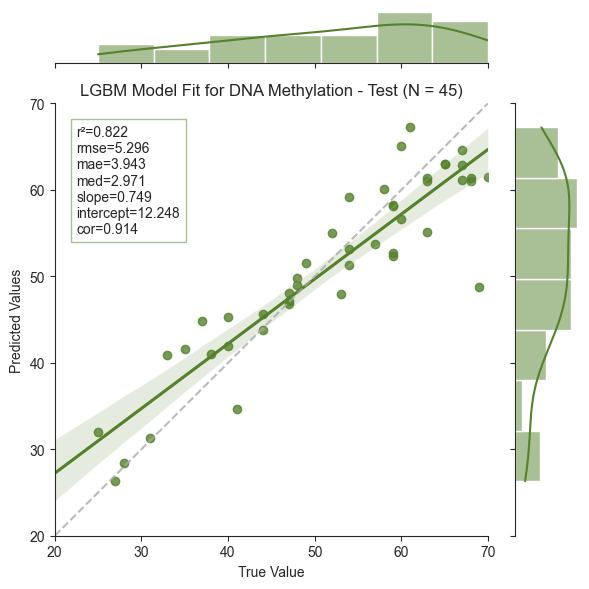

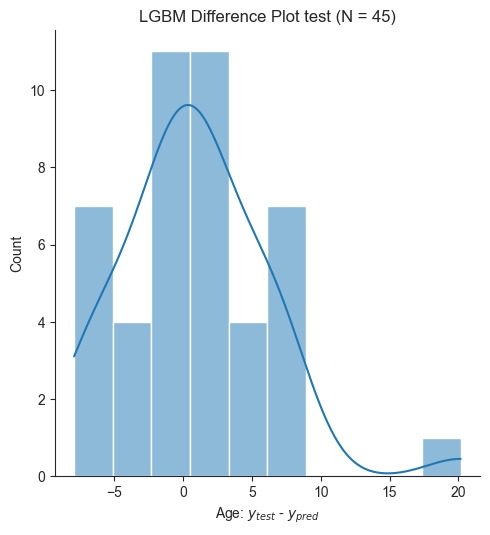

In [32]:
#Plot final model performance (Test)
lgbm.plot_model_fit(X_test_scaled, y_test, title_override = "LGBM Model Fit for DNA Methylation - Test (N = 45)")
lgbm.plot_distplot(X_test_scaled, y_test, type = "test")

In [23]:
# Correlation with covariates
lgbm.compute_correlation(X_test_scaled, y_test, "../../metadata/covariates.csv", exclude_cols = ["ExpID", "MHSMKNMB","MHSMKYRS", "SUBJID"])

c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_stats_py.py:4921: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


,Spearman correlation,p-value
SEX,0.115464,0.450073
BMI,0.044799,0.770127
congestion,0.451839,0.001835
macrophages,-0.075456,0.622272
pneumonia,-0.150315,0.324336
edema,0.038113,0.803699
emphysema,-0.148168,0.331376
calcification,NaN,NaN
atelectasis,0.190563,0.209882
hemorrhage,-0.085555,0.576303


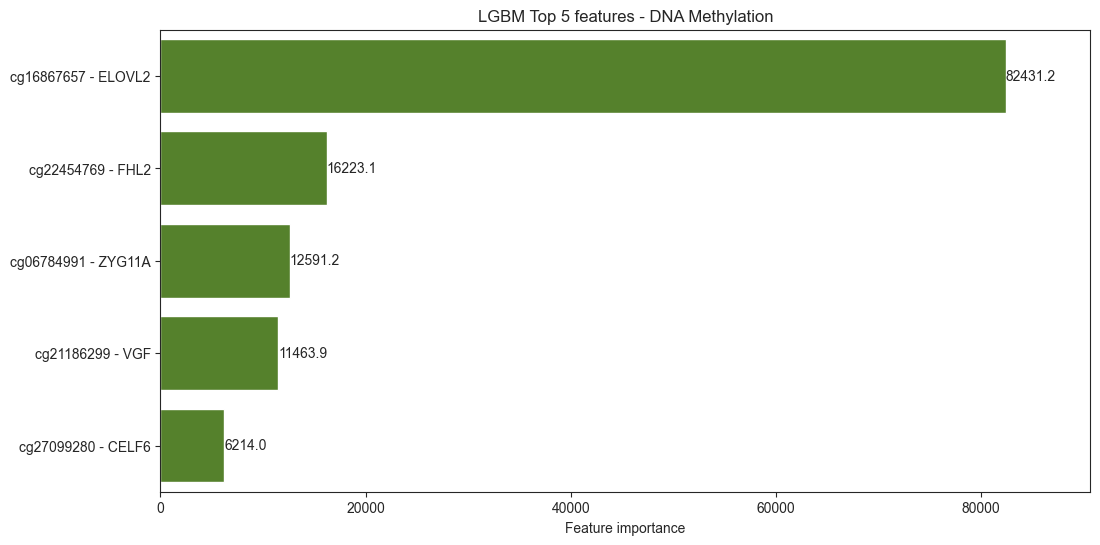

In [42]:
lgbm.plot_top_fetures(5, probe_info)
plt.savefig("LGBM_top_5_features.pdf", format = "pdf", bbox_inches="tight")
#plt.savefig("LGBM_top_5_features.pdf", format="pdf", bbox_inches="tight")

## Correlation with top probes

In [30]:
X_cor = pd.concat([X_train, X_test], axis=0)
y = y_train.copy()
y.extend(y_test)

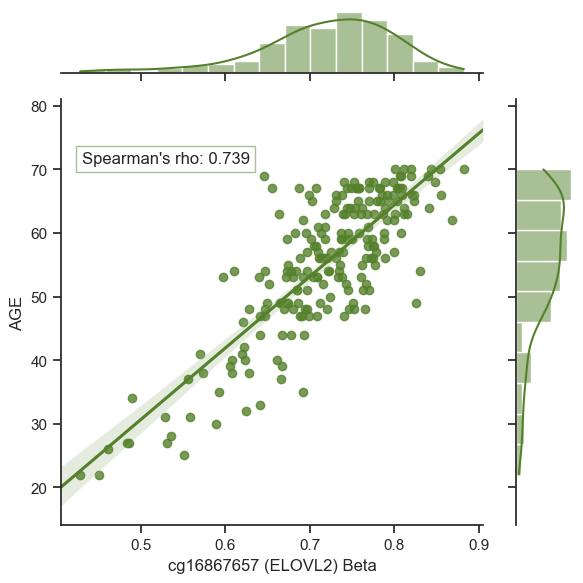

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr


def plot_probe_age_correlation(X, y, probe, probe_name_overwrite = None):
    """
    Compute the correlation between a probe and the age variable, and plot the correlation.

    Parameters:
        X (pandas.DataFrame): Dataset with multiple probes.
        y (pandas.Series): Age variable.
        probe (str): Name of the probe to analyze.

    Returns:
        None
    """
    correlation, _ = spearmanr(X[probe], y)
    
    sns.set_style("ticks")
    #sns.regplot(x=, y=y, scatter_kws={"color": "#55812C"}, line_kws={"color": "darkgray"})
    jointgrid = sns.jointplot(x=X[probe], y=y,
                                  kind="reg",
                                  truncate=False,
                                  scatter=True,
                                  fit_reg=True,
                                  color="#55812C"
                                  )

    if probe_name_overwrite != None:
        jointgrid.ax_joint.set_xlabel(probe_name_overwrite)
    else: 
        jointgrid.ax_joint.set_xlabel(probe)
    jointgrid.ax_joint.set_ylabel("AGE")
    t = plt.text(.05, .85, f"Spearman's rho: {correlation:.3f}", transform=plt.gca().transAxes,
                 bbox=dict(facecolor='white', alpha=0.5, edgecolor="#55812C"))
    plt.tight_layout()
    plt.savefig(f"correlation_{probe}_age.pdf", format = "pdf", bbox_inches="tight")

plot_probe_age_correlation(X_cor, y, "cg16867657", "cg16867657 (ELOVL2) Beta")


## Save results

In [30]:
# Save data
X_train_scaled.to_csv("../../models/age/models.v3/final_model_ARGRegression_top_30_features/X_train_scaled_smogn.csv")
X_test_scaled.to_csv("../../models/age/models.v3/final_model_ARGRegression_top_30_features/X_test_scaled_smogn.csv")
# Save model 
lgbm.model.booster_.save_model(f"../../models/age/models.v3/model_lung_age_ARDRegression_top_30_features.txt")
#Save predictions 
pd.DataFrame({"subject": X_train_scaled.index, "age": smotered_age, "age_pred": y_train_pred}).to_csv("../../models/age/models.v3/final_model_ARGRegression_top_30_features/train_pred.csv")
pd.DataFrame({"subject": X_test_scaled.index, "age": y_test, "age_pred": y_pred}).to_csv("../../models/age/models.v3/final_model_ARGRegression_top_30_features/test_pred.csv")